In [1]:
from sklearn import datasets
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Load the cancer dataset
cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target

# Shuffle the dataset
np.random.seed(43)
shuffled_indices = np.random.permutation(X.shape[0])
X = X[shuffled_indices]
y = y[shuffled_indices]

# PCA
pca = PCA(n_components=4)
X = pca.fit_transform(X)

# Scale Minmaxscaler to [0, π]
scaler = MinMaxScaler(feature_range=(0, 2 * np.pi))
X = scaler.fit_transform(X)


# Select 100 samples from each class (class 0, 1)
samples_per_class = 100
selected_indices = np.hstack([
    np.where(y == class_idx)[0][:samples_per_class] for class_idx in range(2)
])

X_selected = X[selected_indices]
y_selected = y[selected_indices]

print(f"Selected X shape: {X_selected.shape}")
print(f"Selected y shape: {y_selected.shape}")


# Take 16 samples per class for training
train_samples_per_class = 32
train_indices = np.hstack([
    np.where(y_selected == class_idx)[0][:train_samples_per_class] for class_idx in range(2)
])

X_train = X_selected[train_indices]
y_train = y_selected[train_indices]
y_train = np.where(y_train == 0, -1, 1)

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")

# Split the remaining data into testing sets
# Get the indices of the remaining samples (not used for training)
remaining_indices = np.setdiff1d(np.arange(X_selected.shape[0]), train_indices)

X_test = X_selected[remaining_indices]
y_test = y_selected[remaining_indices]


print(f"Test X shape: {X_test.shape}")
print(f"Test y shape: {y_test.shape}")




Selected X shape: (200, 4)
Selected y shape: (200,)
Training X shape: (64, 4)
Training y shape: (64,)
Test X shape: (136, 4)
Test y shape: (136,)


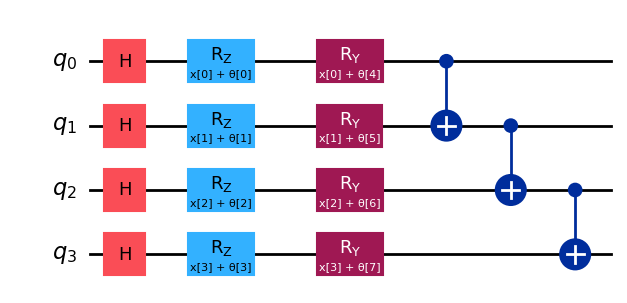

In [80]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

def ansatz(depth, num_qubits):
	"""Create a parametrized quantum circuit for feature mapping."""
	qc = QuantumCircuit(num_qubits)
	data_params = ParameterVector('x', length=num_qubits)

	total_theta_params = num_qubits * depth * 2
	theta_params = ParameterVector('θ', length=total_theta_params)

	for i in range(num_qubits):
		qc.h(i)
    # Repeat layers
	param_idx = 0
	for _ in range(depth):
		for i in range(num_qubits):
			qc.rz(data_params[i] + theta_params[param_idx], i)
			param_idx += 1
		for i in range(num_qubits):
			qc.ry(data_params[i] + theta_params[param_idx], i)
			param_idx += 1
		for i in range(num_qubits - 1):
			qc.cx(i, i + 1)

	return qc

# Example usage
depth = 1
ansatz_circuit = ansatz(depth, num_qubits=4)
ansatz_circuit.draw('mpl')

In [ ]:
#!/usr/bin/env python3
import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd())))

from src.feature_map import TrainableQuantumFeatureMap
from src.kernel_estimate import KernelMatrix

# Train the feature map
depth = 1
tqfm = TrainableQuantumFeatureMap(depth=depth, optimizer='COBYLA', maxiter=200)
tqfm.fit(X_train, y_train, circuit=ansatz(depth, X_train.shape[1]))

# Compute the kernel matrix with the optimized parameters
qkernel = KernelMatrix()
kernel = qkernel.compute_kernel_matrix_with_inner_products(X_train, X_train, tqfm.optimal_params, tqfm.circuit)


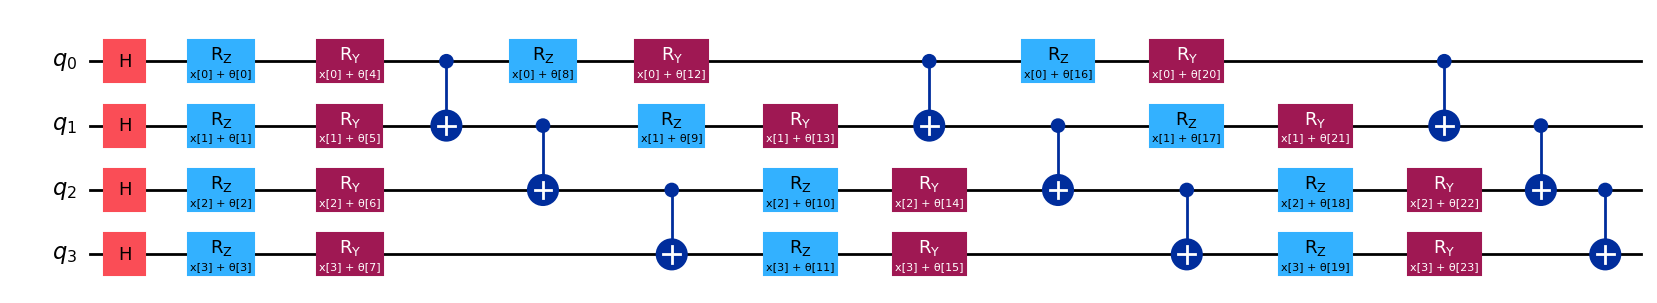

In [98]:
tqfm.circuit.draw('mpl')

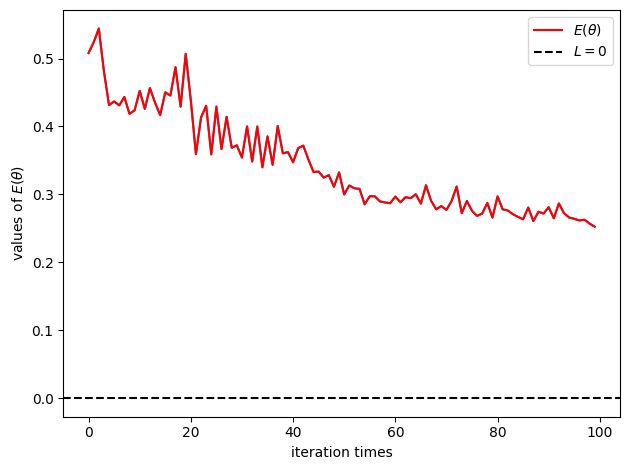

In [110]:
tqfm.plot_loss()

In [111]:
tqfm.optimal_value

np.float64(0.2524921765748659)

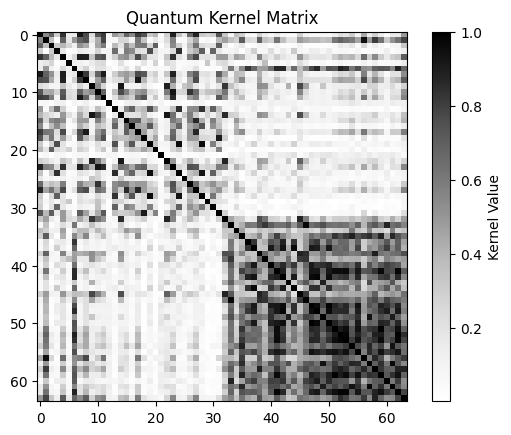

In [112]:
qkernel.plot_kernel_matrix(kernel)

In [102]:
#!/usr/bin/env python3
import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd())))

from src.feature_map import TrainableQuantumFeatureMap
from src.kernel_estimate import KernelMatrix

# Train the feature map
depth = 3
tqfm1 = TrainableQuantumFeatureMap(depth=depth, optimizer='COBYLA', maxiter=200)
tqfm1.fit(X_train, y_train)

# Compute the kernel matrix with the optimized parameters
qkernel1 = KernelMatrix()
kernel1 = qkernel1.compute_kernel_matrix_with_inner_products(X_train, X_train, tqfm1.optimal_params, tqfm1.circuit)


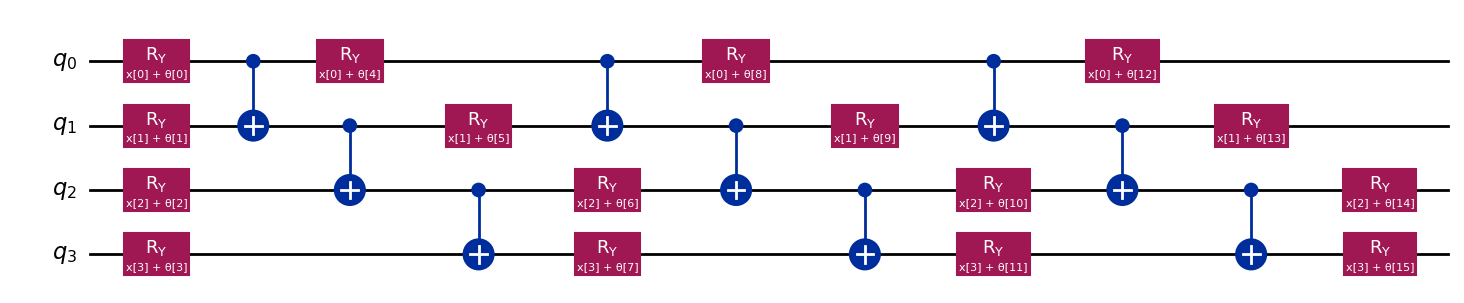

In [103]:
tqfm1.circuit.draw('mpl')

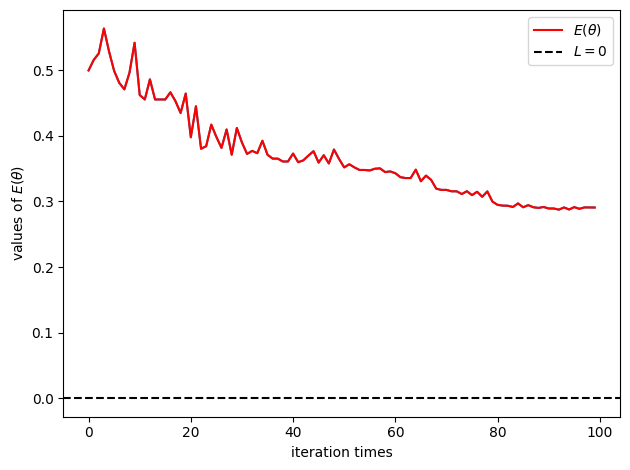

In [104]:
tqfm1.plot_loss()

In [105]:
tqfm1.optimal_value


np.float64(0.2874327841714637)

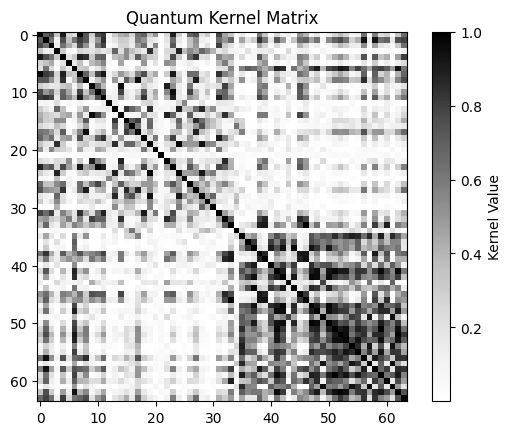

In [106]:
qkernel1.plot_kernel_matrix(kernel1)

In [107]:
kernel_test = qkernel.compute_kernel_matrix_with_inner_products(X_test, X_train, tqfm.optimal_params, tqfm.circuit)
kernel_test1 = qkernel1.compute_kernel_matrix_with_inner_products(X_test, X_train, tqfm1.optimal_params, tqfm1.circuit)

In [ ]:
kernel_test = qkernel.compute_kernel_matrix_with_inner_products(X_test, X_train, tqfm.optimal_params, tqfm.circuit)

In [108]:
from sklearn.svm import SVC

svm = SVC(kernel='precomputed')
svm.fit(kernel, y_train)
y_pred_svm = svm.predict(kernel_test)
accuracy_svm = np.mean(y_pred_svm == np.where(y_test == 0, -1, 1))
print(f"Accuracy: {accuracy_svm * 100:.2f}%")


Accuracy: 96.32%


In [109]:
from sklearn.svm import SVC

svm1 = SVC(kernel='precomputed')
svm1.fit(kernel1, y_train)
y_pred_svm1 = svm1.predict(kernel_test1)
accuracy_svm1 = np.mean(y_pred_svm1 == np.where(y_test == 0, -1, 1))
print(f"Accuracy: {accuracy_svm1 * 100:.2f}%")


Accuracy: 92.65%


In [113]:
# Systematic Depth Analysis: Does Deeper = Better?
import matplotlib.pyplot as plt
import time
from sklearn.svm import SVC

def analyze_depth_performance(depths=[1, 2, 3, 4, 5], max_iter=100):
    """
    Analyze quantum circuit performance across different depths
    """
    results = {
        'depths': [],
        'train_accuracies': [],
        'test_accuracies': [],
        'training_times': [],
        'optimal_values': [],
        'n_parameters': []
    }
    
    for depth in depths:
        print(f"\n{'='*50}")
        print(f"ANALYZING DEPTH = {depth}")
        print(f"{'='*50}")
        
        start_time = time.time()
        
        try:
            # Create ansatz with current depth
            circuit = ansatz(depth, num_qubits=X_train.shape[1])
            
            # Train the feature map
            tqfm = TrainableQuantumFeatureMap(depth=depth, optimizer='COBYLA', maxiter=max_iter)
            tqfm.fit(X_train, y_train, circuit=circuit)
            
            # Compute kernel matrices
            qkernel = KernelMatrix()
            kernel_train = qkernel.compute_kernel_matrix_with_inner_products(
                X_train, X_train, tqfm.optimal_params, tqfm.circuit
            )
            kernel_test = qkernel.compute_kernel_matrix_with_inner_products(
                X_test, X_train, tqfm.optimal_params, tqfm.circuit
            )
            
            # Train SVM and evaluate
            svm = SVC(kernel='precomputed')
            svm.fit(kernel_train, y_train)
            
            # Calculate accuracies
            y_train_pred = svm.predict(kernel_train)
            y_test_pred = svm.predict(kernel_test)
            
            train_acc = np.mean(y_train_pred == y_train)
            test_acc = np.mean(y_test_pred == np.where(y_test == 0, -1, 1))
            
            training_time = time.time() - start_time
            n_params = len(tqfm.optimal_params)
            
            # Store results
            results['depths'].append(depth)
            results['train_accuracies'].append(train_acc)
            results['test_accuracies'].append(test_acc)
            results['training_times'].append(training_time)
            results['optimal_values'].append(tqfm.optimal_value)
            results['n_parameters'].append(n_params)
            
            print(f"✅ Depth {depth}: Train Acc = {train_acc:.3f}, Test Acc = {test_acc:.3f}")
            print(f"   Parameters: {n_params}, Time: {training_time:.1f}s")
            print(f"   Optimal Value: {tqfm.optimal_value:.4f}")
            
        except Exception as e:
            print(f"❌ Depth {depth} failed: {str(e)}")
            continue
    
    return results

# Run the analysis
print("🚀 Starting Systematic Depth Analysis...")
depth_results = analyze_depth_performance(depths=[1, 2, 3, 4], max_iter=150)

🚀 Starting Systematic Depth Analysis...

ANALYZING DEPTH = 1
✅ Depth 1: Train Acc = 0.938, Test Acc = 0.941
   Parameters: 8, Time: 62.6s
   Optimal Value: 0.4151

ANALYZING DEPTH = 2
✅ Depth 1: Train Acc = 0.938, Test Acc = 0.941
   Parameters: 8, Time: 62.6s
   Optimal Value: 0.4151

ANALYZING DEPTH = 2
✅ Depth 2: Train Acc = 0.938, Test Acc = 0.919
   Parameters: 16, Time: 100.3s
   Optimal Value: 0.3134

ANALYZING DEPTH = 3
✅ Depth 2: Train Acc = 0.938, Test Acc = 0.919
   Parameters: 16, Time: 100.3s
   Optimal Value: 0.3134

ANALYZING DEPTH = 3
✅ Depth 3: Train Acc = 0.953, Test Acc = 0.949
   Parameters: 24, Time: 135.5s
   Optimal Value: 0.3366

ANALYZING DEPTH = 4
✅ Depth 3: Train Acc = 0.953, Test Acc = 0.949
   Parameters: 24, Time: 135.5s
   Optimal Value: 0.3366

ANALYZING DEPTH = 4
✅ Depth 4: Train Acc = 0.953, Test Acc = 0.956
   Parameters: 32, Time: 269.4s
   Optimal Value: 0.3504
✅ Depth 4: Train Acc = 0.953, Test Acc = 0.956
   Parameters: 32, Time: 269.4s
   Optimal

C:\Users\Nguyen Dinh Quyen\AppData\Local\Temp\ipykernel_11772\1381554192.py:49: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Nguyen Dinh Quyen\AppData\Local\Temp\ipykernel_11772\1381554192.py:49: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Nguyen Dinh Quyen\AppData\Local\Temp\ipykernel_11772\1381554192.py:49: UserWarning: Glyph 128290 (\N{INPUT SYMBOL FOR NUMBERS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Nguyen Dinh Quyen\AppData\Local\Temp\ipykernel_11772\1381554192.py:49: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Nguyen Dinh Quyen\AppData\Local\Temp\ipykernel_11772\1381554192.py:49: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Nguyen Dinh Quyen\AppData\Local\Temp\ipykernel_11772\1381554192.py:49: User

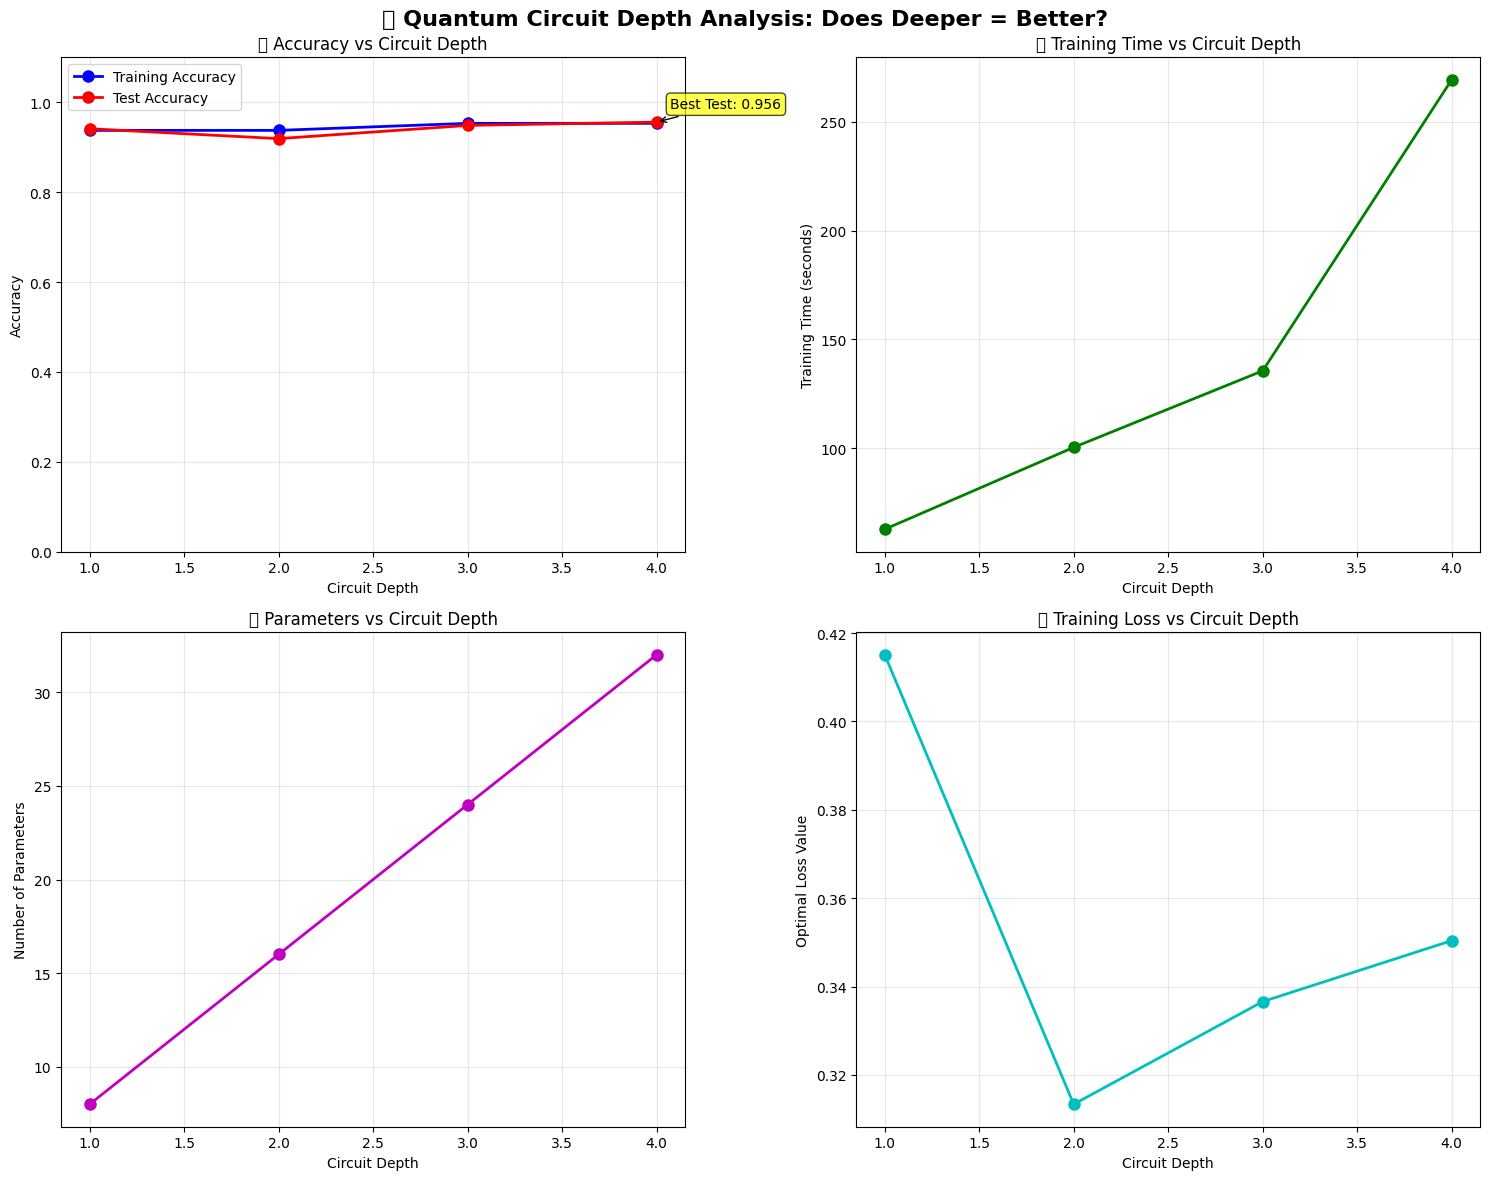


📈 DEPTH ANALYSIS SUMMARY
🏆 Best Test Accuracy: Depth 4 (0.956)
🏆 Best Train Accuracy: Depth 3 (0.953)
⚡ Fastest Training: Depth 1 (62.6s)

🔍 OVERFITTING ANALYSIS:
   Depth 1: Train-Test Gap = -0.004 ✅ Low
   Depth 2: Train-Test Gap = 0.018 ✅ Low
   Depth 3: Train-Test Gap = 0.005 ✅ Low
   Depth 4: Train-Test Gap = -0.003 ✅ Low

⚡ EFFICIENCY ANALYSIS (Test Acc / # Parameters):
   Depth 1: 0.117647 🌟
   Depth 2: 0.057445
   Depth 3: 0.039522
   Depth 4: 0.029871

🎯 RECOMMENDATION:
   🏆 BEST OVERALL DEPTH: 1
   📊 Balanced performance across accuracy, efficiency, and training time

❓ DOES DEEPER = BETTER?
   Overall trend: INCREASING 📈
   ✅ Yes, deeper circuits generally perform better


In [114]:
# Visualize and Analyze Depth Results
def plot_depth_analysis(results):
    """Create comprehensive visualizations of depth analysis"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('📊 Quantum Circuit Depth Analysis: Does Deeper = Better?', fontsize=16, fontweight='bold')
    
    depths = results['depths']
    
    # 1. Accuracy vs Depth
    ax1.plot(depths, results['train_accuracies'], 'bo-', label='Training Accuracy', linewidth=2, markersize=8)
    ax1.plot(depths, results['test_accuracies'], 'ro-', label='Test Accuracy', linewidth=2, markersize=8)
    ax1.set_xlabel('Circuit Depth')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('🎯 Accuracy vs Circuit Depth')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1.1)
    
    # Add best performance markers
    best_test_idx = np.argmax(results['test_accuracies'])
    ax1.annotate(f'Best Test: {results["test_accuracies"][best_test_idx]:.3f}', 
                xy=(depths[best_test_idx], results['test_accuracies'][best_test_idx]),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    # 2. Training Time vs Depth
    ax2.plot(depths, results['training_times'], 'go-', linewidth=2, markersize=8)
    ax2.set_xlabel('Circuit Depth')
    ax2.set_ylabel('Training Time (seconds)')
    ax2.set_title('⏱️ Training Time vs Circuit Depth')
    ax2.grid(True, alpha=0.3)
    
    # 3. Number of Parameters vs Depth
    ax3.plot(depths, results['n_parameters'], 'mo-', linewidth=2, markersize=8)
    ax3.set_xlabel('Circuit Depth')
    ax3.set_ylabel('Number of Parameters')
    ax3.set_title('🔢 Parameters vs Circuit Depth')
    ax3.grid(True, alpha=0.3)
    
    # 4. Optimal Value vs Depth (loss)
    ax4.plot(depths, results['optimal_values'], 'co-', linewidth=2, markersize=8)
    ax4.set_xlabel('Circuit Depth')
    ax4.set_ylabel('Optimal Loss Value')
    ax4.set_title('📉 Training Loss vs Circuit Depth')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical Analysis
    print("\n" + "="*60)
    print("📈 DEPTH ANALYSIS SUMMARY")
    print("="*60)
    
    best_test_depth = depths[np.argmax(results['test_accuracies'])]
    best_train_depth = depths[np.argmax(results['train_accuracies'])]
    fastest_depth = depths[np.argmin(results['training_times'])]
    
    print(f"🏆 Best Test Accuracy: Depth {best_test_depth} ({max(results['test_accuracies']):.3f})")
    print(f"🏆 Best Train Accuracy: Depth {best_train_depth} ({max(results['train_accuracies']):.3f})")
    print(f"⚡ Fastest Training: Depth {fastest_depth} ({min(results['training_times']):.1f}s)")
    
    # Overfitting analysis
    overfitting = np.array(results['train_accuracies']) - np.array(results['test_accuracies'])
    worst_overfitting_idx = np.argmax(overfitting)
    
    print(f"\n🔍 OVERFITTING ANALYSIS:")
    for i, depth in enumerate(depths):
        gap = results['train_accuracies'][i] - results['test_accuracies'][i]
        status = "🚨 High" if gap > 0.1 else "✅ Low" if gap < 0.05 else "⚠️  Medium"
        print(f"   Depth {depth}: Train-Test Gap = {gap:.3f} {status}")
    
    # Efficiency analysis (accuracy per parameter)
    efficiency = np.array(results['test_accuracies']) / np.array(results['n_parameters'])
    most_efficient_idx = np.argmax(efficiency)
    
    print(f"\n⚡ EFFICIENCY ANALYSIS (Test Acc / # Parameters):")
    for i, depth in enumerate(depths):
        eff = efficiency[i]
        star = " 🌟" if i == most_efficient_idx else ""
        print(f"   Depth {depth}: {eff:.6f}{star}")
    
    # Final recommendation
    print(f"\n🎯 RECOMMENDATION:")
    
    # Score each depth based on multiple criteria
    scores = {}
    for i, depth in enumerate(depths):
        score = 0
        score += results['test_accuracies'][i] * 40  # Test accuracy (40% weight)
        score += (1 - overfitting[i]) * 20  # Low overfitting (20% weight)
        score += efficiency[i] * 100 * 20  # Efficiency (20% weight)
        score += (1 - results['training_times'][i] / max(results['training_times'])) * 20  # Speed (20% weight)
        scores[depth] = score
    
    best_overall_depth = max(scores, key=scores.get)
    
    print(f"   🏆 BEST OVERALL DEPTH: {best_overall_depth}")
    print(f"   📊 Balanced performance across accuracy, efficiency, and training time")
    
    # Answer the original question
    test_accs = results['test_accuracies']
    if len(test_accs) > 1:
        if test_accs[-1] > test_accs[0]:  # Last depth > first depth
            trend = "INCREASING 📈"
        elif test_accs[-1] < test_accs[0]:  # Last depth < first depth  
            trend = "DECREASING 📉"
        else:
            trend = "STABLE 📊"
    else:
        trend = "INSUFFICIENT DATA"
        
    print(f"\n❓ DOES DEEPER = BETTER?")
    print(f"   Overall trend: {trend}")
    
    if trend == "INCREASING 📈":
        print("   ✅ Yes, deeper circuits generally perform better")
    elif trend == "DECREASING 📉":
        print("   ❌ No, deeper circuits may lead to overfitting or optimization issues")
    else:
        print("   🤷 Mixed results - optimal depth depends on the specific problem")
    
    print("="*60)

# Generate the analysis
if 'depth_results' in locals() and len(depth_results['depths']) > 0:
    plot_depth_analysis(depth_results)
else:
    print("⚠️ Run the depth analysis first to see the results!")

In [115]:
# Systematic Depth Analysis: Does Deeper = Better?
import matplotlib.pyplot as plt
import time
from sklearn.svm import SVC

def analyze_depth_performance(depths=[1, 2, 3, 4, 5], max_iter=100):
    """
    Analyze quantum circuit performance across different depths
    """
    results = {
        'depths': [],
        'train_accuracies': [],
        'test_accuracies': [],
        'training_times': [],
        'optimal_values': [],
        'n_parameters': []
    }
    
    for depth in depths:
        print(f"\n{'='*50}")
        print(f"ANALYZING DEPTH = {depth}")
        print(f"{'='*50}")
        
        start_time = time.time()
        
        try:
            
            # Train the feature map
            tqfm = TrainableQuantumFeatureMap(depth=depth, optimizer='COBYLA', maxiter=max_iter)
            tqfm.fit(X_train, y_train)
			# Note: Using default ansatz inside TrainableQuantumFeatureMap
            # Compute kernel matrices
            qkernel = KernelMatrix()
            kernel_train = qkernel.compute_kernel_matrix_with_inner_products(
                X_train, X_train, tqfm.optimal_params, tqfm.circuit
            )
            kernel_test = qkernel.compute_kernel_matrix_with_inner_products(
                X_test, X_train, tqfm.optimal_params, tqfm.circuit
            )
            
            # Train SVM and evaluate
            svm = SVC(kernel='precomputed')
            svm.fit(kernel_train, y_train)
            
            # Calculate accuracies
            y_train_pred = svm.predict(kernel_train)
            y_test_pred = svm.predict(kernel_test)
            
            train_acc = np.mean(y_train_pred == y_train)
            test_acc = np.mean(y_test_pred == np.where(y_test == 0, -1, 1))
            
            training_time = time.time() - start_time
            n_params = len(tqfm.optimal_params)
            
            # Store results
            results['depths'].append(depth)
            results['train_accuracies'].append(train_acc)
            results['test_accuracies'].append(test_acc)
            results['training_times'].append(training_time)
            results['optimal_values'].append(tqfm.optimal_value)
            results['n_parameters'].append(n_params)
            
            print(f"✅ Depth {depth}: Train Acc = {train_acc:.3f}, Test Acc = {test_acc:.3f}")
            print(f"   Parameters: {n_params}, Time: {training_time:.1f}s")
            print(f"   Optimal Value: {tqfm.optimal_value:.4f}")
            
        except Exception as e:
            print(f"❌ Depth {depth} failed: {str(e)}")
            continue
    
    return results

# Run the analysis
print("🚀 Starting Systematic Depth Analysis...")
depth_results = analyze_depth_performance(depths=[1, 2, 3, 4], max_iter=150)

🚀 Starting Systematic Depth Analysis...

ANALYZING DEPTH = 1
✅ Depth 1: Train Acc = 0.938, Test Acc = 0.941
   Parameters: 8, Time: 55.2s
   Optimal Value: 0.2977

ANALYZING DEPTH = 2
✅ Depth 1: Train Acc = 0.938, Test Acc = 0.941
   Parameters: 8, Time: 55.2s
   Optimal Value: 0.2977

ANALYZING DEPTH = 2
✅ Depth 2: Train Acc = 0.953, Test Acc = 0.956
   Parameters: 12, Time: 76.5s
   Optimal Value: 0.2321

ANALYZING DEPTH = 3
✅ Depth 2: Train Acc = 0.953, Test Acc = 0.956
   Parameters: 12, Time: 76.5s
   Optimal Value: 0.2321

ANALYZING DEPTH = 3
✅ Depth 3: Train Acc = 0.969, Test Acc = 0.941
   Parameters: 16, Time: 99.4s
   Optimal Value: 0.2822

ANALYZING DEPTH = 4
✅ Depth 3: Train Acc = 0.969, Test Acc = 0.941
   Parameters: 16, Time: 99.4s
   Optimal Value: 0.2822

ANALYZING DEPTH = 4
✅ Depth 4: Train Acc = 0.953, Test Acc = 0.963
   Parameters: 20, Time: 120.4s
   Optimal Value: 0.2597
✅ Depth 4: Train Acc = 0.953, Test Acc = 0.963
   Parameters: 20, Time: 120.4s
   Optimal Val

C:\Users\Nguyen Dinh Quyen\AppData\Local\Temp\ipykernel_11772\1381554192.py:49: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Nguyen Dinh Quyen\AppData\Local\Temp\ipykernel_11772\1381554192.py:49: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Nguyen Dinh Quyen\AppData\Local\Temp\ipykernel_11772\1381554192.py:49: UserWarning: Glyph 128290 (\N{INPUT SYMBOL FOR NUMBERS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Nguyen Dinh Quyen\AppData\Local\Temp\ipykernel_11772\1381554192.py:49: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Nguyen Dinh Quyen\AppData\Local\Temp\ipykernel_11772\1381554192.py:49: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Nguyen Dinh Quyen\miniconda3\envs\SVQSVM\Lib\site-packages\IPython\core\pyl

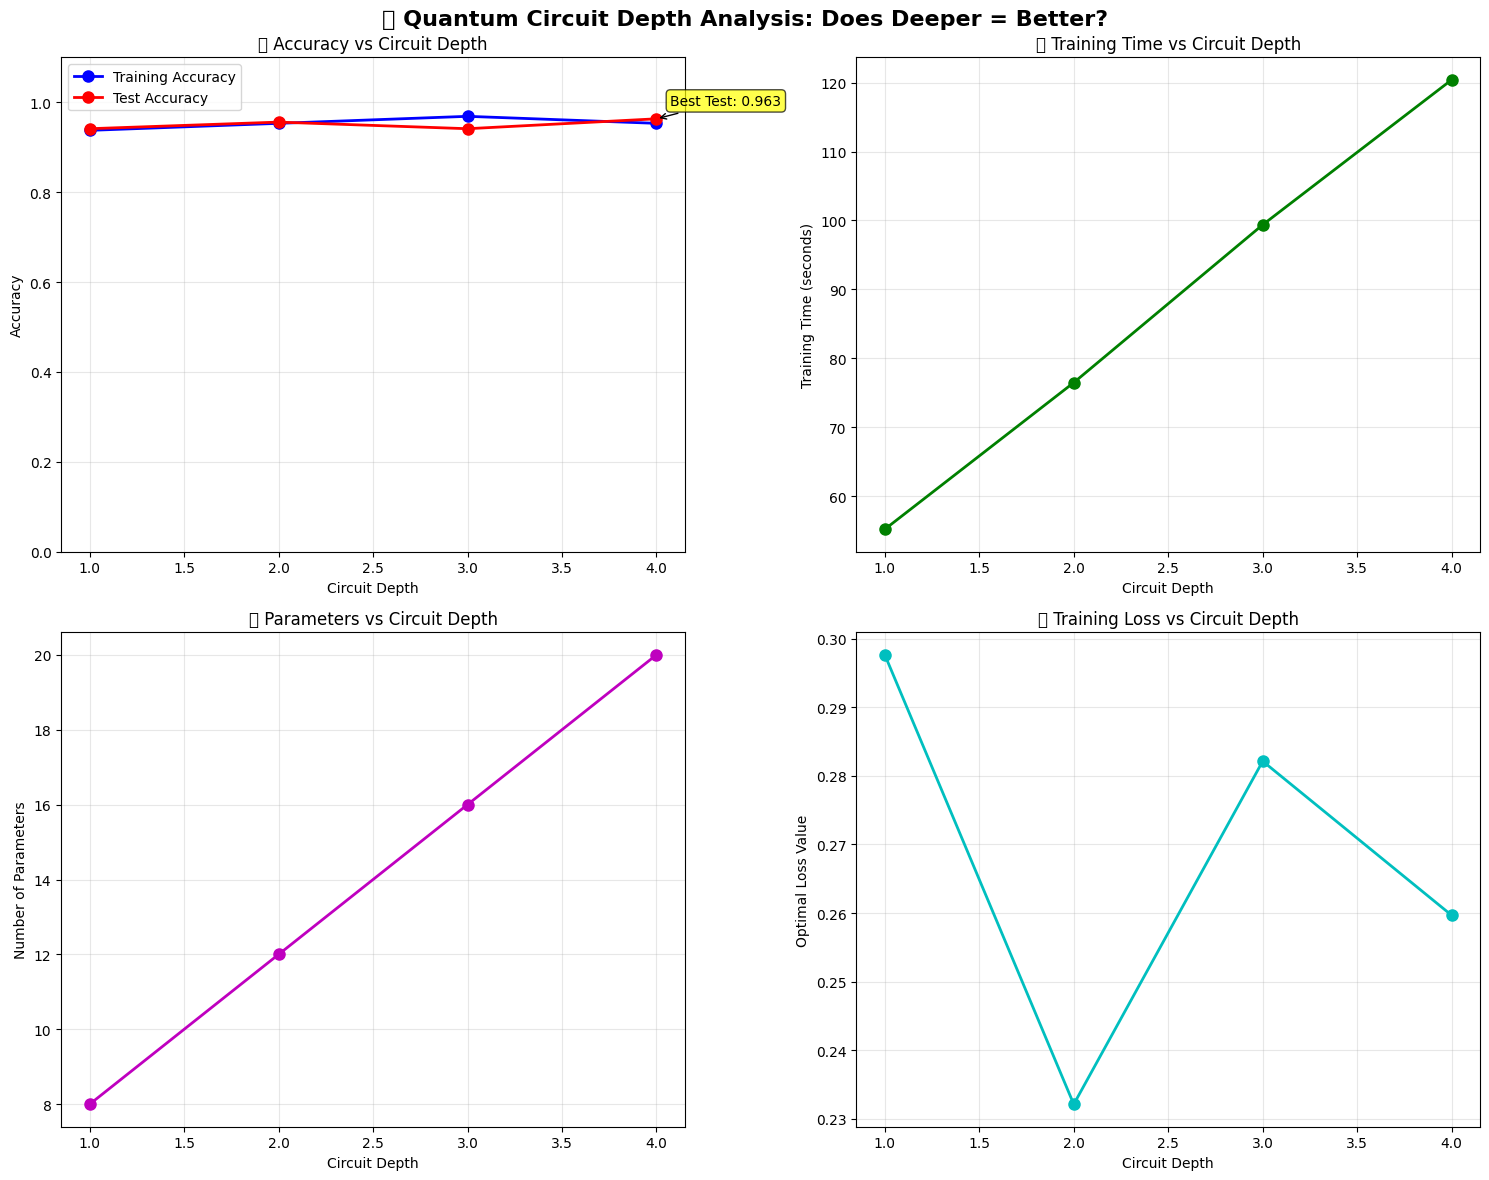


📈 DEPTH ANALYSIS SUMMARY
🏆 Best Test Accuracy: Depth 4 (0.963)
🏆 Best Train Accuracy: Depth 3 (0.969)
⚡ Fastest Training: Depth 1 (55.2s)

🔍 OVERFITTING ANALYSIS:
   Depth 1: Train-Test Gap = -0.004 ✅ Low
   Depth 2: Train-Test Gap = -0.003 ✅ Low
   Depth 3: Train-Test Gap = 0.028 ✅ Low
   Depth 4: Train-Test Gap = -0.010 ✅ Low

⚡ EFFICIENCY ANALYSIS (Test Acc / # Parameters):
   Depth 1: 0.117647 🌟
   Depth 2: 0.079657
   Depth 3: 0.058824
   Depth 4: 0.048162

🎯 RECOMMENDATION:
   🏆 BEST OVERALL DEPTH: 1
   📊 Balanced performance across accuracy, efficiency, and training time

❓ DOES DEEPER = BETTER?
   Overall trend: INCREASING 📈
   ✅ Yes, deeper circuits generally perform better


In [116]:
# Visualize and Analyze Depth Results
def plot_depth_analysis(results):
    """Create comprehensive visualizations of depth analysis"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('📊 Quantum Circuit Depth Analysis: Does Deeper = Better?', fontsize=16, fontweight='bold')
    
    depths = results['depths']
    
    # 1. Accuracy vs Depth
    ax1.plot(depths, results['train_accuracies'], 'bo-', label='Training Accuracy', linewidth=2, markersize=8)
    ax1.plot(depths, results['test_accuracies'], 'ro-', label='Test Accuracy', linewidth=2, markersize=8)
    ax1.set_xlabel('Circuit Depth')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('🎯 Accuracy vs Circuit Depth')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1.1)
    
    # Add best performance markers
    best_test_idx = np.argmax(results['test_accuracies'])
    ax1.annotate(f'Best Test: {results["test_accuracies"][best_test_idx]:.3f}', 
                xy=(depths[best_test_idx], results['test_accuracies'][best_test_idx]),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    # 2. Training Time vs Depth
    ax2.plot(depths, results['training_times'], 'go-', linewidth=2, markersize=8)
    ax2.set_xlabel('Circuit Depth')
    ax2.set_ylabel('Training Time (seconds)')
    ax2.set_title('⏱️ Training Time vs Circuit Depth')
    ax2.grid(True, alpha=0.3)
    
    # 3. Number of Parameters vs Depth
    ax3.plot(depths, results['n_parameters'], 'mo-', linewidth=2, markersize=8)
    ax3.set_xlabel('Circuit Depth')
    ax3.set_ylabel('Number of Parameters')
    ax3.set_title('🔢 Parameters vs Circuit Depth')
    ax3.grid(True, alpha=0.3)
    
    # 4. Optimal Value vs Depth (loss)
    ax4.plot(depths, results['optimal_values'], 'co-', linewidth=2, markersize=8)
    ax4.set_xlabel('Circuit Depth')
    ax4.set_ylabel('Optimal Loss Value')
    ax4.set_title('📉 Training Loss vs Circuit Depth')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical Analysis
    print("\n" + "="*60)
    print("📈 DEPTH ANALYSIS SUMMARY")
    print("="*60)
    
    best_test_depth = depths[np.argmax(results['test_accuracies'])]
    best_train_depth = depths[np.argmax(results['train_accuracies'])]
    fastest_depth = depths[np.argmin(results['training_times'])]
    
    print(f"🏆 Best Test Accuracy: Depth {best_test_depth} ({max(results['test_accuracies']):.3f})")
    print(f"🏆 Best Train Accuracy: Depth {best_train_depth} ({max(results['train_accuracies']):.3f})")
    print(f"⚡ Fastest Training: Depth {fastest_depth} ({min(results['training_times']):.1f}s)")
    
    # Overfitting analysis
    overfitting = np.array(results['train_accuracies']) - np.array(results['test_accuracies'])
    worst_overfitting_idx = np.argmax(overfitting)
    
    print(f"\n🔍 OVERFITTING ANALYSIS:")
    for i, depth in enumerate(depths):
        gap = results['train_accuracies'][i] - results['test_accuracies'][i]
        status = "🚨 High" if gap > 0.1 else "✅ Low" if gap < 0.05 else "⚠️  Medium"
        print(f"   Depth {depth}: Train-Test Gap = {gap:.3f} {status}")
    
    # Efficiency analysis (accuracy per parameter)
    efficiency = np.array(results['test_accuracies']) / np.array(results['n_parameters'])
    most_efficient_idx = np.argmax(efficiency)
    
    print(f"\n⚡ EFFICIENCY ANALYSIS (Test Acc / # Parameters):")
    for i, depth in enumerate(depths):
        eff = efficiency[i]
        star = " 🌟" if i == most_efficient_idx else ""
        print(f"   Depth {depth}: {eff:.6f}{star}")
    
    # Final recommendation
    print(f"\n🎯 RECOMMENDATION:")
    
    # Score each depth based on multiple criteria
    scores = {}
    for i, depth in enumerate(depths):
        score = 0
        score += results['test_accuracies'][i] * 40  # Test accuracy (40% weight)
        score += (1 - overfitting[i]) * 20  # Low overfitting (20% weight)
        score += efficiency[i] * 100 * 20  # Efficiency (20% weight)
        score += (1 - results['training_times'][i] / max(results['training_times'])) * 20  # Speed (20% weight)
        scores[depth] = score
    
    best_overall_depth = max(scores, key=scores.get)
    
    print(f"   🏆 BEST OVERALL DEPTH: {best_overall_depth}")
    print(f"   📊 Balanced performance across accuracy, efficiency, and training time")
    
    # Answer the original question
    test_accs = results['test_accuracies']
    if len(test_accs) > 1:
        if test_accs[-1] > test_accs[0]:  # Last depth > first depth
            trend = "INCREASING 📈"
        elif test_accs[-1] < test_accs[0]:  # Last depth < first depth  
            trend = "DECREASING 📉"
        else:
            trend = "STABLE 📊"
    else:
        trend = "INSUFFICIENT DATA"
        
    print(f"\n❓ DOES DEEPER = BETTER?")
    print(f"   Overall trend: {trend}")
    
    if trend == "INCREASING 📈":
        print("   ✅ Yes, deeper circuits generally perform better")
    elif trend == "DECREASING 📉":
        print("   ❌ No, deeper circuits may lead to overfitting or optimization issues")
    else:
        print("   🤷 Mixed results - optimal depth depends on the specific problem")
    
    print("="*60)

# Generate the analysis
if 'depth_results' in locals() and len(depth_results['depths']) > 0:
    plot_depth_analysis(depth_results)
else:
    print("⚠️ Run the depth analysis first to see the results!")